## baseline fit and covariance estimation

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from multiprocessing import Pool
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm.notebook import tqdm

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
plot_labels = fh.fancy_labels

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
    
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 47289,
  "iopub_port": 47451,
  "stdin_port": 57053,
  "control_port": 42935,
  "hb_port": 46065,
  "ip": "127.0.0.1",
  "key": "aa522aff-22877469b028c9f00b197b32",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-ba4bcef4-3c5b-4249-a686-f910de4795c9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'gjets', 'diboson', 'fakes'] 
selections = [
    'ee',  
    'mumu',  
    'emu', 
    'etau',  
    'mutau',
    'ejet', 
    'mujet',
             ]
veto_list = [
    
    # baseline categories
    #'ee_cat_gt2_eq1_b',  #'mumu_cat_gt2_eq1_b', 
    #'ee_cat_gt2_gt2_b',  #'mumu_cat_gt2_gt2_b', 
    
    #'emu_cat_gt2_eq1_a', 'emu_cat_gt2_gt2_a', 
    #'etau_cat_eq2_eq1', 'etau_cat_gt3_eq1', 
    #'etau_cat_eq2_gt2', 'etau_cat_gt3_gt2', 
    #'mutau_cat_eq2_gt2', 'mutau_cat_gt3_gt2', 
    #'mutau_cat_eq2_eq1', 'mutau_cat_gt3_eq1', 
    
    #'ejet_cat_gt4_eq1',  #'mujet_cat_gt4_eq1', 
    #'ejet_cat_gt4_gt2', #'mujet_cat_gt4_gt2', 
    
    # experimental semi-leptonic
    'ejet_cat_eq3_gt2', 'mujet_cat_eq3_gt2',
    
    # e/mu DY CR (*fobidden*)
    'ee_cat_gt2_eq0',  'mumu_cat_gt2_eq0', 
    
    # e+mu additional ttbar
    #'emu_cat_gt2_eq0', 'emu_cat_eq1_eq0_a', #'emu_cat_eq1_eq1_a',
    
    # e+mu WW
    #'emu_cat_eq0_eq0_a', 
    
    # e/mu+tau additional CR
    #'mutau_cat_eq0_eq0', 'mutau_cat_eq1_eq0', 
    #'mutau_cat_gt2_eq0', 'mutau_cat_eq1_eq1', 
    #'etau_cat_eq0_eq0', 'etau_cat_eq1_eq0', 
    #'etau_cat_gt2_eq0', 'etau_cat_eq1_eq1', 
    
    # e/mu+tau old categorization
    #'etau_cat_gt2_eq1_a', 'etau_cat_gt2_gt2_a', 
    #'mutau_cat_gt2_eq1_a', 'mutau_cat_gt2_gt2_a', 
    
]

# initialize fit data
input_dir  = f'local_data/templates/test_08242020_jetavg/'
fit_data = fh.FitData(input_dir, selections, processes, 
                      param_file = 'data/model_parameters_test.csv',
                      use_prefit = False,
                      process_cut = 0.05,
                      veto_list   = veto_list,
                      debug_mode  = False,
                      ratio_test  = False
                     )

In [3]:
# prepare Asimov dataset
parameters = fit_data._parameters
params_pre = parameters['val_init'].values
if fit_data._ratio_test:
    params_pre[:2] = params_pre[2]
    asimov_data = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}
    params_pre[:2] = 1.
else:
    asimov_data = {cat:fit_data.mixture_model(params_pre, cat) for cat in fit_data._model_data.keys()}

# randomize initial values and values of constraints
#fit_data._pval_init[4:] += np.random.randn(fit_data._nparams - 4)*fit_data._perr_init[4:]

In [4]:
# fit configuration #
scenario = 'fake_factorization_tight'

# minimizer options
min_options = dict(#eps=1e-9, 
                   gtol = 1e-3,
                   disp = True
                  )

# configure the objective
#fit_data._pmask[4:] = False
mask = fit_data._pmask.copy()
if scenario == 'asimov':
    sample = asimov_data
else:
    sample = None
    
fobj = partial(fit_data.objective,
               data = sample,
               do_bb_lite = True,
               no_shape = False,
               lu_test = 0,
              )

fobj_jac = partial(fit_data.objective_jacobian,
                   data = sample,
                   do_bb_lite = True,
                   no_shape = False,
                   lu_test = 0
                  )


In [5]:
# carry out fit for null hypothesis
result_null = minimize(fobj, params_pre[mask],
                       jac = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )

print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

         Current function value: 259.621303
         Iterations: 76
         Function evaluations: 136
         Gradient evaluations: 125
 null :  2 259.6213033695527 [10.895 10.895 10.895 67.316]


In [6]:
# carry out fit for null hypothesis
#result_null = minimize(fobj, params_pre[mask],
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = {'verbose': 2, 'gtol':1.},
#                       args = ()
#                      )
#
#print(' null : ', result_null.status, result_null.fun, result_null.x[:4]*100)

In [7]:
# carry out fit for alt 1
fobj.keywords['lu_test'] = 1
fobj_jac.keywords['lu_test'] = 1
result_alt1 = minimize(fobj, params_pre[mask],
                       jac     = fobj_jac,
                       method  = 'BFGS', 
                       options = min_options,
                       args = ()
                      )
        
print(' alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

         Current function value: 259.347847
         Iterations: 77
         Function evaluations: 148
         Gradient evaluations: 137
 alt. 1:  2 259.3478472594328 [10.908 10.908 10.772 67.412]


In [8]:
# carry out fit for alt hypothesis
#fobj.keywords['lu_test'] = 1
#fobj_jac.keywords['lu_test'] = 1
#pinit = result_null.x.copy()
#result_alt1 = minimize(fobj, pinit,
#                       jac = fobj_jac,
#                       hess = '2-point',
#                       method  = 'trust-constr', 
#                       #method  = 'BFGS', 
#                       options = {'verbose': 2, 'gtol':0.1},
#                       args = ()
#                      )
#
#print('alt. 1: ', result_alt1.status, result_alt1.fun, result_alt1.x[:4]*100)

In [9]:
# carry out fit for alt 2
fobj.keywords['lu_test'] = 2
fobj_jac.keywords['lu_test'] = 2
result_alt2 =  minimize(fobj, params_pre[mask],
                        jac     = fobj_jac,
                        method  = 'BFGS', 
                        options = min_options,
                        #bounds  = bnds,
                       )

print(' alt. 2: ', result_alt2.status, result_alt2.fun, result_alt2.x[:4]*100)

         Current function value: 258.679862
         Iterations: 74
         Function evaluations: 137
         Gradient evaluations: 125
 alt. 2:  2 258.6798623076466 [10.832 10.935 10.768 67.464]


In [10]:
# Wilk's theorem
from scipy.stats import chi2, norm
q1 = 2*(result_null.fun - result_alt1.fun)
z1 = -norm.ppf(chi2.sf(q1, 1))

q2 = 2*(result_null.fun - result_alt2.fun)
z2 = -norm.ppf(chi2.sf(q2, 2))

print(f' test hypothesis 1: q = {q1:.1f}, z = {z1:.1f}')
print(f' test hypothesis 2: q = {q2:.1f}, z = {z2:.1f}')

 test hypothesis 1: q = 0.5, z = 0.1
 test hypothesis 2: q = 1.9, z = 0.3


In [11]:

# calculate covariance matrix assuming LU
print('Calculating covariance for null hypothesis (LU)...')
p_mle_lu = result_null.x
fobj.keywords['lu_test'] = 0
fobj_jac.keywords['lu_test'] = 0
stderr_lu, corr_lu = fh.calculate_covariance(fobj, p_mle_lu)

#print(f'BR: {p_mle_lu[:2]}')
#print(f'err: {stderr_lu[:2]}')
#print(corr_lu[:4, :4])

# stats only w/ LU
fit_data._pmask[4:] = False
result_stat_lu =  minimize(fobj, params_pre[:4],
                           jac     = fobj_jac,
                           method  = 'BFGS', 
                           options = min_options,
                           #bounds  = bnds,
                          )
p_stat = result_stat_lu.x
err_stat_lu, _ = fh.calculate_covariance(fobj, p_stat)
err_stat_lu = np.concatenate([err_stat_lu, np.zeros(params_pre.size - 4)])
fit_data._pmask = parameters['active'].values.astype(bool)

# calculate covariance matrix assuming semi-LU
print('Calculating covariance for partial LU hypothesis...')
p_mle_plu = result_alt1.x
fobj.keywords['lu_test'] = 1
fobj_jac.keywords['lu_test'] = 1
stderr_plu, corr_plu = fh.calculate_covariance(fobj, p_mle_plu)
      
#print(f'BR: {p_mle_plu[:3]}')
#print(f'err: {stderr_plu[:3]}')
#print(corr_plu[:4, :4])

# calculate covariance matrix from the inverse of the Hessian of the NLL
print('Calculating covariance for non-LU hypothesis...')
p_mle = result_alt2.x
fobj.keywords['lu_test'] = 2
fobj_jac.keywords['lu_test'] = 2
stderr, corr = fh.calculate_covariance(fobj, p_mle)

df_results = pd.DataFrame()

# no MC stat
print('Calculating covariance without MC stats nuisance parameters...')
fit_data._pmask = parameters['active'].values.astype(bool)
mask = fit_data._pmask.copy()
fobj.keywords['do_bb_lite'] = False
fobj_jac.keywords['do_bb_lite'] = False
result_no_bb =  minimize(fobj, params_pre[mask],
                    jac     = fobj_jac,
                    method  = 'BFGS', 
                    options = min_options,
                    #bounds  = bnds,
                    )
p_no_bb = result_no_bb.x
err_no_bb, _ = fh.calculate_covariance(fobj, p_no_bb)

# stat only
print('Calculating covariance without any nuisance parameters...')
fit_data._pmask[4:] = False
result_stat =  minimize(fobj, params_pre[:4],
                    jac     = fobj_jac,
                    method  = 'BFGS', 
                    options = min_options,
                    #bounds  = bnds,
                    )
p_stat = result_stat.x
err_stat, _ = fh.calculate_covariance(fobj, p_stat)
err_stat = np.concatenate([err_stat, np.zeros(p_mle.size - 4)])


# w/ MC stat, but no systematics
#print('Calculating covariance with only MC stat nuisance parameters...')
fobj.keywords['do_bb_lite'] = True
fobj_jac.keywords['do_bb_lite'] = True
#err_mc_stat_alt, _ = fh.calculate_covariance(fobj, p_mle[:4])
#err_mc_stat_alt = np.concatenate([err_mc_stat_alt, np.zeros(p_mle.size - 4)])

# combine components
err_syst = np.sqrt(np.abs(err_no_bb**2 - err_stat**2))
err_mc_stat = np.sqrt(np.abs(stderr**2 - err_no_bb**2))
#err_mc_stat_alt = np.sqrt(err_mc_stat_alt**2 - err_stat**2)

Calculating covariance for null hypothesis (LU)...
         Current function value: 529.161757
         Iterations: 6
         Function evaluations: 35
         Gradient evaluations: 23
Calculating covariance for partial LU hypothesis...
Calculating covariance for non-LU hypothesis...
Calculating covariance without MC stats nuisance parameters...
Optimization terminated successfully.
         Current function value: 462.940434
         Iterations: 96
         Function evaluations: 111
         Gradient evaluations: 111
Calculating covariance without any nuisance parameters...
         Current function value: 898.417970
         Iterations: 11
         Function evaluations: 51
         Gradient evaluations: 41


In [12]:
# plot errors
parameters = fit_data._parameters
parameters['val_fit'] = parameters['val_init'].copy()
parameters['err_fit'] = parameters['err_init'].copy()
parameters.loc[mask, 'val_fit'] = result_alt2.x
parameters.loc[mask, 'err_fit'] = stderr
parameters['ratio'] = parameters.err_fit/parameters.err_init

parameters['val_no_bb'] = parameters['val_init'].copy()
parameters['err_no_bb'] = parameters['err_init'].copy()
parameters.loc[mask, 'val_no_bb'] = p_no_bb
parameters.loc[mask, 'err_no_bb'] = err_no_bb

parameters['val_stat'] = parameters['val_init'].copy()
parameters['err_stat'] = parameters['err_init'].copy()
mask[4:] = False
parameters.loc[mask, 'val_stat'] = p_stat
parameters.loc[mask, 'err_stat'] = err_stat[:4]
parameters.loc[~mask, 'err_stat'] = 0.
mask = parameters['active'].values.astype(bool)

# scale branching fraction values
#param_mask = np.array(parameters.type == 'poi', dtype=bool)
#val_init = parameters.loc[param_mask, 'val_init']
#parameters.loc[param_mask, 'err_init'] *= 100/val_init
#parameters.loc[param_mask, 'err_fit'] *= 100/val_init

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', parameters.shape[0])
pd.set_option('display.max_rows', parameters.shape[0])

# plot nuisance parameter errors and constraints
parameters.set_index('label')
parameters.to_csv(f'data/model_parameters_{scenario}.csv')

In [13]:
# save fit data as input to full fit
outfile = open(f'local_data/fit_data_{scenario}.pkl', 'wb')
fit_data._pmask = parameters['active'].values.astype(bool)
pickle.dump(fit_data, outfile)
outfile.close()
###

df = 100*parameters.query('active == 1')
df['err_syst'] = np.sqrt(df['err_fit'].values**2 - df['err_stat'].values**2)
df['err_mc_stat'] = np.sqrt(df['err_fit']**2 - df['err_no_bb']**2)
df = df[['val_init',  'val_fit', 'val_stat', 'val_no_bb', 'err_init', 'err_fit', 'err_stat', 'err_syst', 'err_no_bb', 'err_mc_stat', 'ratio']]
#df = df[['val_init', 'err_init', 'val_stat', 'err_stat', 'val_no_bb', 'err_no_bb', 'val_fit', 'err_fit', 'ratio']]
df = df.astype('float64')
#df[:4].style.bar(subset=['ratio'], align='mid', color=['#d65f5f', '#5fba7d']).set_precision(3)
df[:4].style.bar(subset=['ratio'], align='mid', color=['#d65f5f', '#5fba7d']).set_precision(3)

/home/naodell/opt/anaconda3.8/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,val_init,val_fit,val_stat,val_no_bb,err_init,err_fit,err_stat,err_syst,err_no_bb,err_mc_stat,ratio
name,,,,,,,,,,,
beta_e,10.800,10.832,10.504,10.715,10.800,0.104,0.012,0.103,0.091,0.049,0.959
beta_mu,10.800,10.935,10.590,10.888,10.800,0.083,0.010,0.083,0.072,0.042,0.773
beta_tau,10.800,10.768,10.595,10.715,10.800,0.212,0.046,0.207,0.179,0.113,1.960
beta_h,67.600,67.464,68.311,67.682,67.600,0.282,0.044,0.279,0.242,0.145,0.418


In [14]:
# produce correlation matrix
p_labels = list(parameters.index)
p_labels_fancy = fit_data._parameters.label[mask]

# full fit
df_corr = pd.DataFrame(corr, columns=p_labels_fancy, index=p_labels_fancy)
df_corr.to_latex(f'local_data/corr_table_full_{scenario}.tex')
df_corr.to_csv(f'local_data/corr_table_full_{scenario}.csv')

# partial LU fit
df_corr_plu = pd.DataFrame(corr_plu, columns=p_labels_fancy, index=p_labels_fancy)
df_corr_plu.to_latex(f'local_data/corr_table_full_plu_{scenario}.tex')
df_corr_plu.to_csv(f'local_data/corr_table_full_plu_{scenario}.csv')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


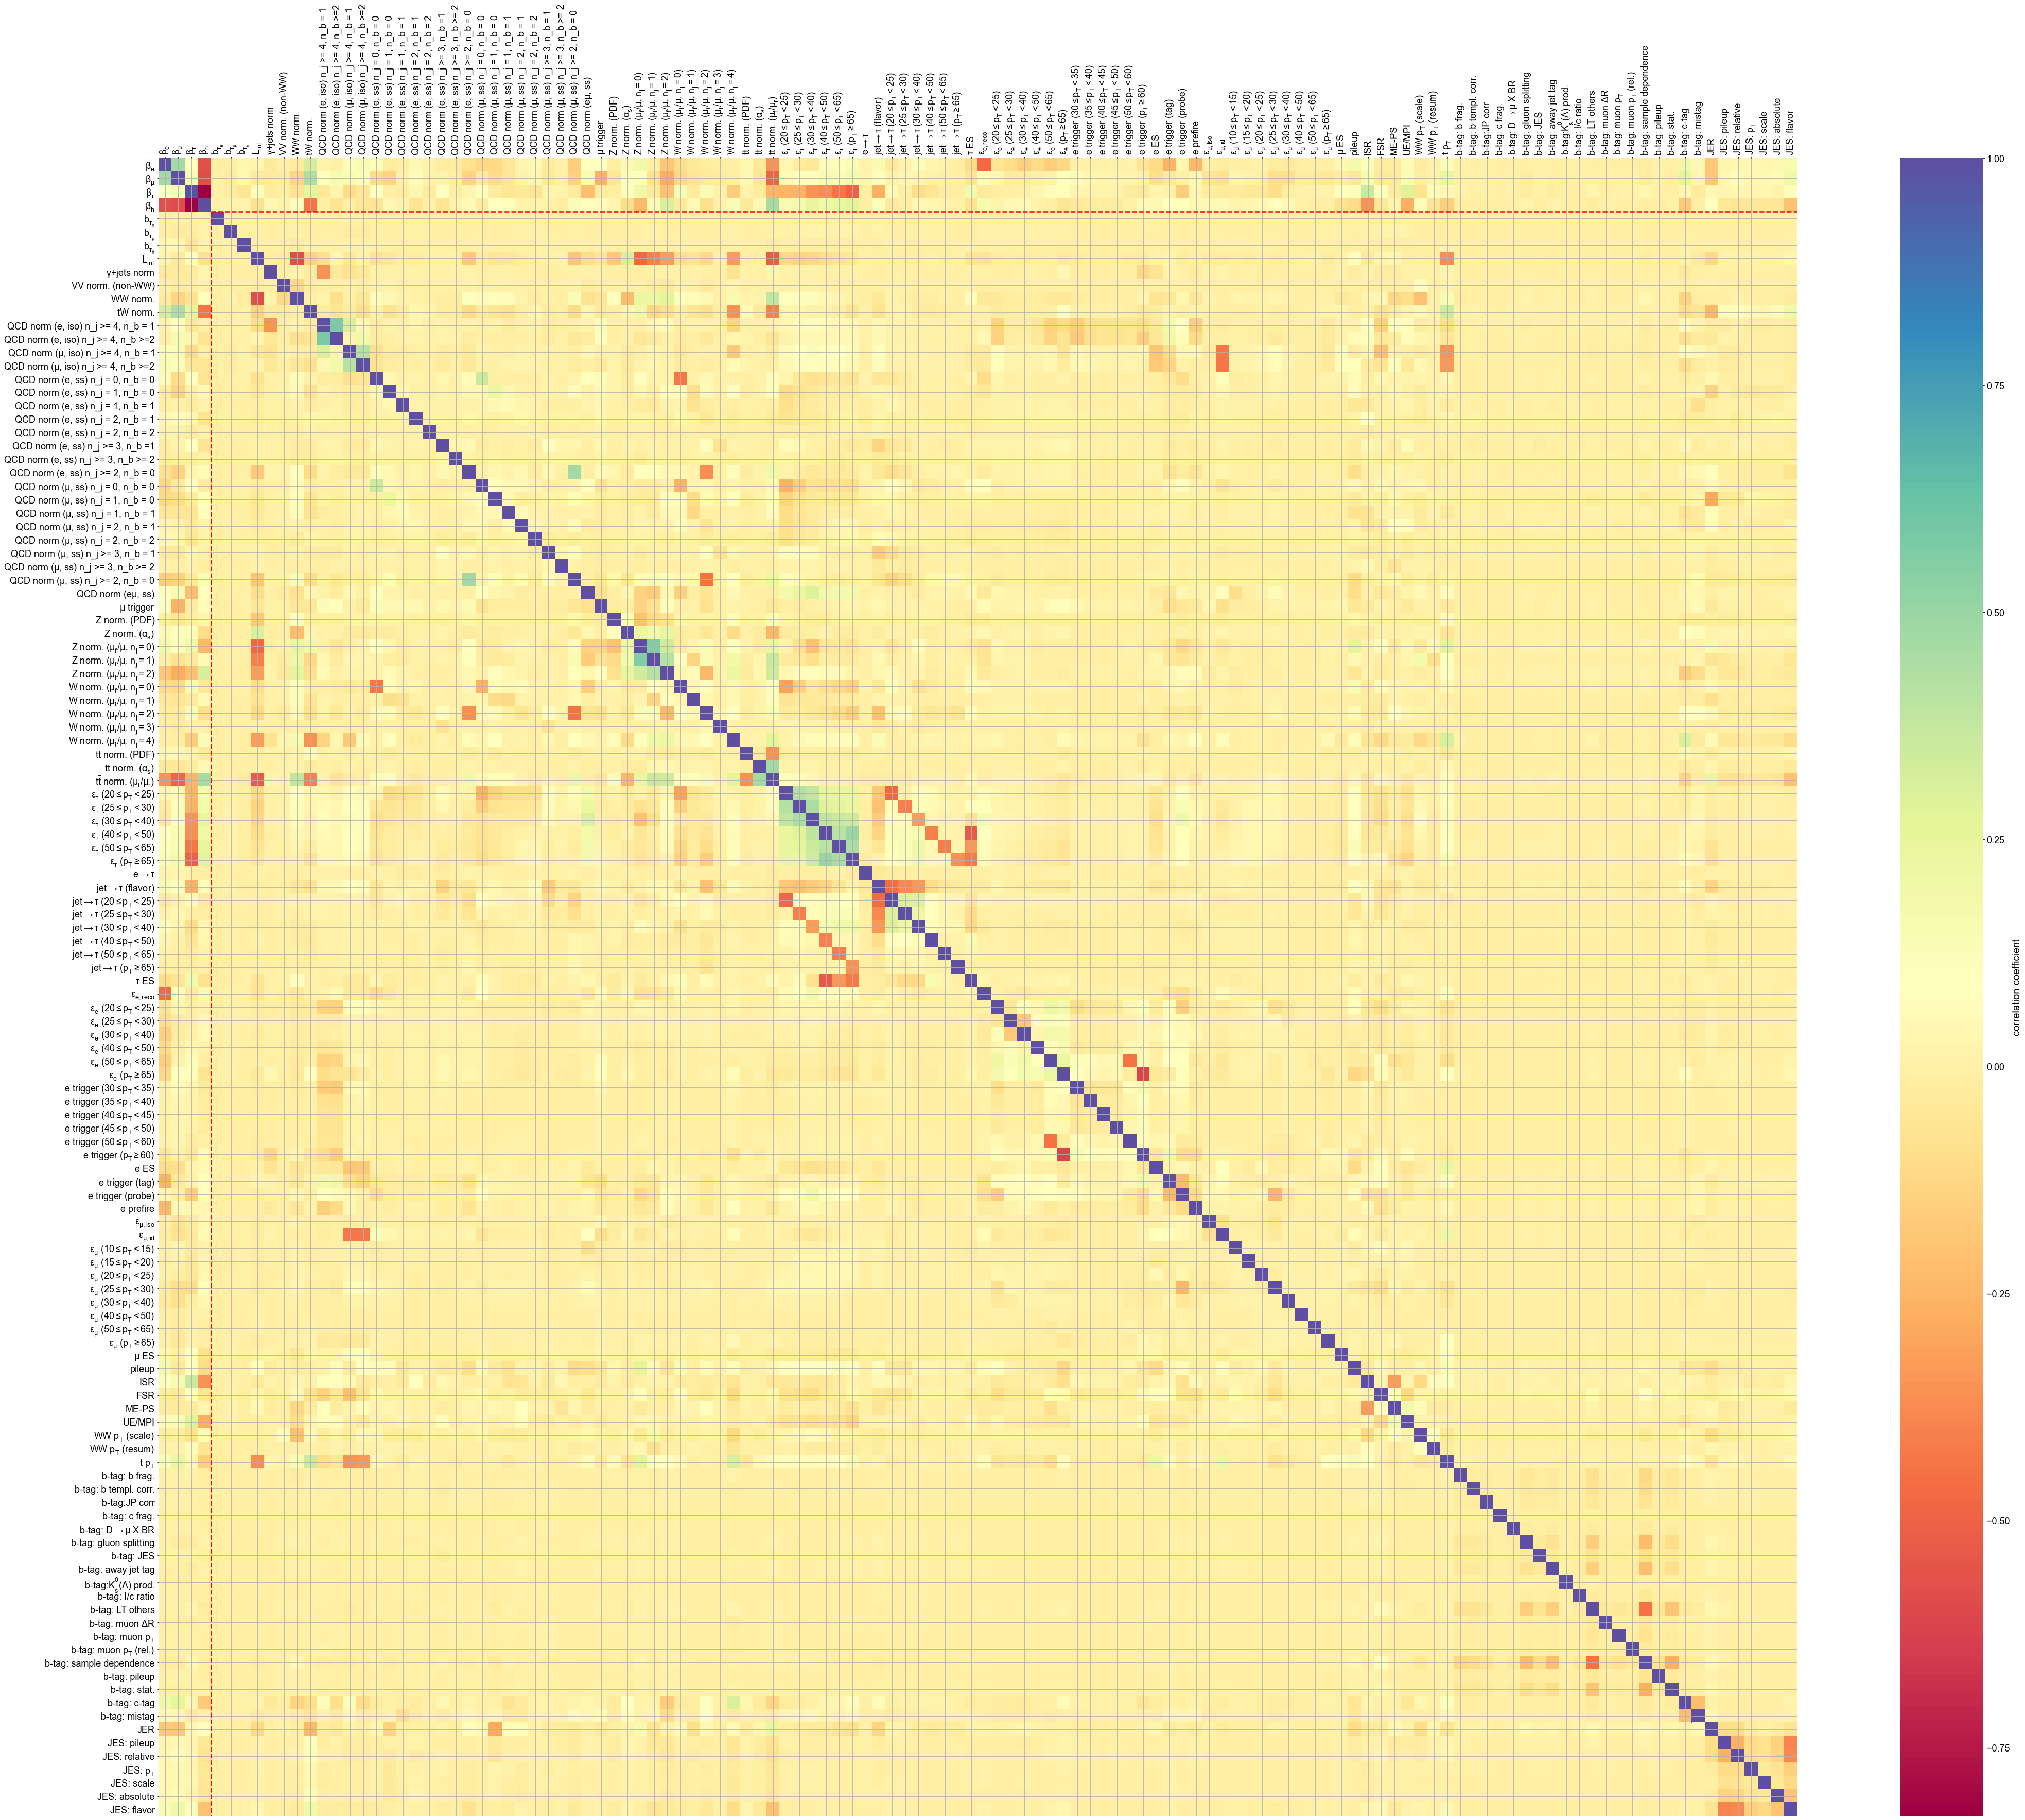

In [15]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(60, 50))
sns.heatmap(df_corr, cmap='Spectral', annot=False, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
plt.plot([4, df_corr.shape[0]], [4, 4], 'r--')
plt.plot([4, 4], [4, df_corr.shape[0]], 'r--')
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()
ax.grid()
#ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/systematics/correlation_matrix_{scenario}.pdf')
plt.show()

[0.959 0.773 1.96  2.615] [0.959 0.773 1.96  2.615]


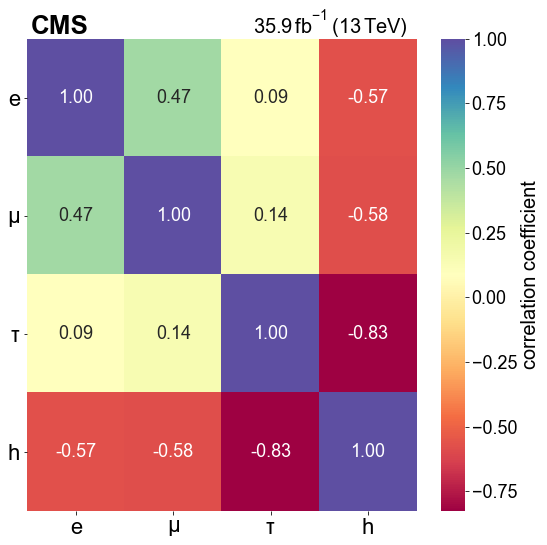

In [37]:
# produce correlation matrix
fig, axes = plt.subplots(1, 1, facecolor='white', figsize=(8, 8))

ax = axes
sns.heatmap(df_corr.iloc[:4, :4], cmap='Spectral', annot=True, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
ax.set_xlabel('')
ax.set_ylabel('')
#ax.xaxis.tick_top()
#ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
ax.set_xticklabels(['e', r'$\mu$', r'$\tau$', 'h'], fontsize=22)
ax.set_yticklabels(['e', r'$\mu$', r'$\tau$', 'h'], fontsize=22)
plt.yticks(rotation=0)

ax.text(0.01, 1.01, 'CMS',                                                  
        fontsize=26,                                                        
        fontname='Arial',                                                   
        fontweight='bold',                                                  
        transform=ax.transAxes                                              
        )                                                                   
#ax.text(0.17, 1.01, 'Preliminary',                                              
#        fontsize=20,                                                      
#        fontname='Arial',                                                   
#        fontstyle='italic',                                                 
#        transform=ax.transAxes                                              
#        )                                                                   
ax.text(0.58, 1.01,
        r'$\mathsf{{ {0:.1f}\,fb^{{-1}}}}\,(13\,\mathsf{{TeV}})$'.format(35.9),
        fontsize=20,                                                      
        fontname='Arial',                                                   
        transform=ax.transAxes                                              
        )                                                                   


# transform W branching fraction covariance by marginalizing over nuisance parameters
cov = corr*np.outer(stderr, stderr)
cov_inv = np.linalg.pinv(cov)
U0 = cov_inv[:4, :4]
V = cov_inv[:4, 4:]
W0_inv = np.linalg.pinv(cov_inv[4:, 4:])
IX = np.dot(V, np.dot(W0_inv, V.T))
U = (U0 - IX)

cov_new = np.linalg.pinv(U)
err_new = np.sqrt(cov_new.diagonal())
corr_new =  cov_new/np.outer(err_new, err_new)
df_corr_marginal = pd.DataFrame(corr_new, columns=p_labels_fancy[:4], index=p_labels_fancy[:4])
print(100*err_new[:4]/0.108, 100*stderr[:4]/0.108)

#ax = axes[1]
#sns.heatmap(df_corr_marginal, cmap='Spectral', annot=True, fmt='.2f', ax=ax, cbar_kws={'label': r'correlation coefficient'})
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.xaxis.tick_top()
##ax.xaxis.set_ticks(np.arange(0, df_corr.shape[0], 1))
#plt.xticks(rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(f'plots/systematics/correlation_matrix_POI_{scenario}.pdf')
plt.show()

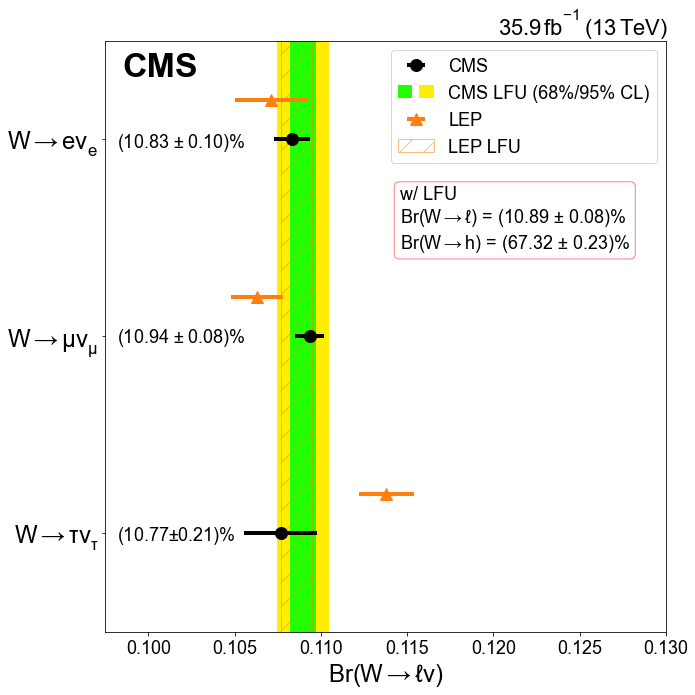

In [38]:
# presentation of results
fig, axes = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

ax = axes
br_cms = result_alt2.x[:4]
p0 = ax.errorbar(br_cms[2::-1], np.arange(3), xerr=stderr[2::-1], 
            fmt='ko',
            markersize=12.,
            capsize=0.,
            elinewidth=4,
            label='CMS'
           )
br_lep_lu = result_null.x[0]
br_had_lu = result_null.x[3]
#ax.plot(2*[br_lu,], [-0.5, 2.5], 'C0--')
colors = ['#22FF00', '#FFEE00']
p1 = ax.fill_betweenx([-0.5, 2.5], br_lep_lu-stderr_lu[0], br_lep_lu+stderr_lu[0], alpha=1., facecolor=colors[0], label='CMS w/ LU')
p2 = ax.fill_betweenx([-0.5, 2.5], br_lep_lu-2*stderr_lu[0], br_lep_lu-stderr_lu[0], alpha=1., facecolor=colors[1])
ax.fill_betweenx([-0.5, 2.5], br_lep_lu+stderr_lu[0], br_lep_lu+2*stderr_lu[0], alpha=1., facecolor=colors[1])

lep_val = [0.1071, 0.1063, 0.1138]
lep_err = [0.0016, 0.0015, 0.0021]
p3 = ax.errorbar(lep_val[::-1], np.arange(3) + 0.2, xerr=lep_err, 
            fmt='C1^',
            markersize=12.,
            capsize=0.,
            elinewidth=4,
            label='LEP'
           )
lep_avg = 0.1086, 0.0009
p4 = ax.fill_betweenx([-0.5, 2.5], lep_avg[0]-lep_avg[1], lep_avg[0]+lep_avg[1], 
                 alpha=0.5, 
                 hatch='/', 
                 edgecolor='C1', 
                 facecolor='none', 
                 label='LEP w/ LU'
                )

#combined_val = [.1080, .1088, .1104]
#combined_err = [0.00085, 0.0007, 0.00146]
#p_combined = ax.errorbar(combined_val[::-1], np.arange(3) - 0.2, xerr=combined_err[::-1],
#                         fmt='C0v',
#                         markersize=12.,
#                         capsize=0.,
#                         elinewidth=4,
#                         label='CMS+LEP'
#                        )
#combined_avg = 0.10883, 0.00058
#p_combined_average = ax.fill_betweenx([-0.5, 2.5], combined_avg[0]-combined_avg[1], combined_avg[0]+combined_avg[1], 
#                                      alpha=0.5, 
#                                      hatch='\\', 
#                                      edgecolor='C0', 
#                                      facecolor='none', 
#                                      label='CMS+LEP w/ LU'
#                                     )

ax.text(0.02, 0.82 , f'({100*br_cms[0]:.2f}' + r' $\pm$ ' + f'{100*stderr[0]:.2f})%',
        fontsize=18,
        fontname='Arial',     
        color='k',
        transform=ax.transAxes
       )
ax.text(0.02, 0.49, f'({100*br_cms[1]:.2f}' + r' $\pm$ ' + f'{100*stderr[1]:.2f})%',
        fontsize=18,
        fontname='Arial',     
        color='k',
        transform=ax.transAxes
       )
ax.text(0.02, 0.155, f'({100*br_cms[2]:.2f}' + r'$ \pm $' + f'{100*stderr[2]:.2f})%',
        fontsize=18,          
        fontname='Arial',     
        color='k',
        transform=ax.transAxes
       )

#ax.text(0.54, 0.7, r'$Br(W\rightarrow h)\,(counting) = 67.08 \pm 0.72 \%$',
#        fontsize=16,          
#        color='C0',
#        fontname='Arial',     
#        transform=ax.transAxes
#       )
#ax.text(0.54, 0.55, r'$Br(W\rightarrow h)$ = ' + f'{100*br_cms[3]:.2f}' + r' $\pm$ ' + f'{stderr[3]:.2%}',
#        fontsize=16,          
#        color='k',
#        fontname='Arial',     
#        transform=ax.transAxes
#       )
ax.text(0.525, 0.65, 
        'w/ LFU \n'
        + r'$Br(W\rightarrow \ell)$ = ' + f'({100*br_lep_lu:.2f}' + r' $\pm$ ' + f'{100*stderr_lu[0]:.2f})%' + '\n' 
        + r'$Br(W\rightarrow h)$ = ' + f'({100*br_had_lu:.2f}' + r' $\pm$ ' + f'{100*stderr_lu[3]:.2f})%',
        fontsize=18,
        color='k',
        fontname='Arial',     
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(1., 0.5, 0.5),
            fc=(1., 1., 1.),
           )
       )
#ax.text(f'{br_cms[1]}' + r'$\pm$' + f'{stderr[1]}')
#ax.text(f'{br_cms[2]}' + r'$\pm$' + f'{stderr[2]}')

ax.set_yticks([0, 1, 2])
ax.set_yticklabels([r'$W\rightarrow \tau\nu_{\tau}$', r'$W\rightarrow \mu\nu_{\mu}$', r'$W\rightarrow e\nu_{e}$'], fontsize=24)
ax.set_ylim(-0.5, 2.5)
ax.set_xlim(0.0975, 0.13)
ax.set_xlabel(r'Br($W\rightarrow\ell\nu$)', fontsize=24)
from matplotlib.legend_handler import HandlerTuple
ax.legend([p0, [p1, p2], p3, p4], 
          ['CMS', 'CMS LFU (68%/95% CL)', 'LEP', 'LEP LFU'], 
          handler_map = {list: HandlerTuple(None)},
          fontsize=18,
          loc=1
         )
#ax.legend([p0, [p1, p2], p3, p4, p_combined, p_combined_average], 
#          ['CMS', 'CMS LU (68%/95% CL)', 'LEP', 'LEP LU', 'CMS+LEP', 'CMS+LEP LU'], 
#          handler_map = {list: HandlerTuple(None)},
#          fontsize=18,
#          loc=1
#         )

ax.text(0.03, 0.94, 'CMS',                                                     
        fontsize=34,                                                        
        fontname='Arial',                                                   
        fontweight='bold',                                                  
        transform=ax.transAxes                                              
        )                                                                   
#ax.text(0.14, 1.01, 'Preliminary',                                         
#        fontsize=18,                                                       
#        fontname='Arial',                                                  
#        fontstyle='italic',                                                
#        transform=ax.transAxes                                             
#        )                                                                  
ax.text(0.70, 1.01,                                                         
        r'$\mathsf{{ {0:.1f}\,fb^{{-1}}}}\,(13\,\mathsf{{TeV}})$'.format(35.9),
        fontsize=22,                                                        
        fontname='Arial',                                                   
        transform=ax.transAxes                                              
        )                                                                   

plt.tight_layout()
plt.savefig(f'plots/summary_plot_{scenario}.pdf')
plt.show()

In [43]:
# calculation of CKM quantities and alpha_s (taken from LEP EW combo arXiv:1302.3415 p.95)
#alpha_s, alpha_s_err = 0.112, 0.001 # Ziheng's values
alpha_s, alpha_s_err = 0.1202, 0.001
r_w = br_had_lu/(1 - br_had_lu)
r_w_err = stderr_lu[3]/(1 - br_had_lu)**2

print(f'B_had = {br_had_lu:.5f} +/- {stderr_lu[3]:.5f}')
print(f'R_W (CMS) = {r_w:.4f} +/- {r_w_err:.4f}')

# combine with LEP values
r_w_lep = 0.6741/(1 - 0.6741)
r_w_lep_err = 0.0027/(1 - 0.6741)**2 

print(f'R_W (LEP) = {r_w_lep:.4f} +/- {r_w_lep_err:.4f}')

r_w_var_avg = 1/(1/r_w_lep_err**2 + 1/r_w_err**2)
r_w_avg = (r_w_lep/r_w_lep_err**2 + r_w/r_w_err**2)*r_w_var_avg

print(f'R_w (LEP+CMS) = {r_w_avg:.4f} +/- {np.sqrt(r_w_var_avg):.4f}')

#r_w = r_w_avg
#r_w_err = np.sqrt(r_w_var_avg)
#r_w = r_w_lep
#r_w_err = r_w_lep_err

# calculation of alpha_s (assume CKM unitarity)
alpha_s_exp = np.pi*(r_w/2 - 1)
alpha_s_exp_err = np.pi*r_w_err/2

print(f'alpha_s = {alpha_s_exp:.4f} +/- {alpha_s_exp_err:.4f}')

# calculation of sum_ij |V_ij|^2 
vij = r_w/(1 + alpha_s/np.pi)
dvij_dr_w = 1./(1 + alpha_s/np.pi)
dvij_dalpha_s = -r_w/(np.pi*(1 + alpha_s/np.pi)**2)
vij_var = (dvij_dr_w*r_w_err)**2 + (dvij_dalpha_s*alpha_s_err)**2 

print(f'sum_ij |V_ij|^2 = {vij:.4f} +/- {np.sqrt(vij_var):.4f}')

# calculation of V_cs (= 0.987 +/- 0.011 in PDG2020)
v_ij = np.array([0.97370, 0.2245, 0.221, 0.0410, 0.00382])
v_ij_err = np.array([0.00014, 0.0008, 0.004, 0.0014, 0.00024])
sum_ckm = np.sum(v_ij**2)
sum_ckm_err = np.dot(4*v_ij**2, v_ij_err)

print(f'sum_ij |V_ij|^2 (ij != cs) = {sum_ckm:.4f} +/- {sum_ckm_err:.4f}')

v_cs = np.sqrt(r_w/(1 + alpha_s/np.pi) - sum_ckm)

dv_cs_dr_w = 1/(2*(1 + alpha_s/np.pi)*v_cs)
dv_cs_dalpha_s = -r_w/(2*np.pi*v_cs*(1 + alpha_s/np.pi)**2)
dv_cs_dsum_ckm = -1/(2*v_cs)

v_cs_var = (dv_cs_dr_w*r_w_err)**2 + (dv_cs_dalpha_s*alpha_s_err)**2 + (dv_cs_dsum_ckm*sum_ckm_err)**2

print(f'V_cs = {v_cs:.4f} +/- {np.sqrt(v_cs_var):.4f}')

B_had = 0.67316 +/- 0.00227
R_W (CMS) = 2.0596 +/- 0.0213
R_W (LEP) = 2.0684 +/- 0.0254
R_w (LEP+CMS) = 2.0632 +/- 0.0163
alpha_s = 0.0936 +/- 0.0334
sum_ij |V_ij|^2 = 1.9837 +/- 0.0205
sum_ij |V_ij|^2 (ij != cs) = 1.0490 +/- 0.0015
V_cs = 0.9668 +/- 0.0106


In [19]:
# same, but using arXiv:2005:04545
r_w = br_had_lu/(1 - br_had_lu)
r_w_err = stderr_lu[3]/(1 - br_had_lu)**2

r_w_th = 2.0812
r_w_th_err = 0.0011

sum_vij = 2*r_w/r_w_th
sum_vij_err = sum_vij*np.sqrt((r_w_th_err/r_w_th)**2 + (r_w_err/r_w)**2)

print(f'sum_vij = {sum_vij:.4f} +/- {sum_vij_err:.4f}')

#CKM matrix elements (experimental)
alpha_s_0 = 0.1179
v_cd = (0.218, 0.004)
v_cs = (0.997, 0.017)
sum_v_ij = (2.043, 0.034)

#CKM matrix elements (unitarity)
#v_cd = (0.22438, 0.00044)
#v_cs = (0.997, 0.017)
#sum_v_ij = (2.043, 0.034)

# exp CKM coefficients
gamma_0_lep = 677.59
gamma_0_had = 1440.28
c1 = 1446.61
c2 = 734.557
c3 = 53.76
c6 = -1.24411

a_cx = v_cs[0]**2 + v_cd[0]**2
delta_gamma = (gamma_0_lep*r_w - gamma_0_had)

# v_cs calculation
v_cs_exp = np.sqrt((delta_gamma/c2 + 1)*a_cx - v_cd[0]**2)
v_cs_exp_err = a_cx*gamma_0_lep*r_w_err/(2*c2*v_cs_exp)
print(f'v_cs = {v_cs_exp:.4f} +/- {v_cs_exp_err:.4f}')

# exp CKM coefficients (unitarity)
gamma_0_had = 1410.21
c1 = 1409.59
c2 = 0
c3 = 52.34
c6 = -1.15932

delta_gamma = (gamma_0_lep*r_w - gamma_0_had)
# alpha_s calculation
delta_alpha_s = (-c3 + np.sqrt(c3**2 + 4*c6*delta_gamma))/(2*c6)
alpha_s = alpha_s_0*(1 + delta_alpha_s)
alpha_s_err = alpha_s_0*gamma_0_lep*r_w_err/np.sqrt(c3**2 + 4*c6*delta_gamma)

#delta_alpha_s = delta_gamma/c3
#alpha_s_err = alpha_s_0*gamma_0_lep*r_w_err/c3

#alpha_s = np.pi*(r_w/2 - 1)
#alpha_s_err = np.pi*r_w_err/2

print(f'alpha_s = {alpha_s:.4f} +/- {alpha_s_err:.4f}')

sum_vij = 1.9792 +/- 0.0205
v_cs = 0.9647 +/- 0.0106
alpha_s = 0.0851 +/- 0.0321
